In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [4]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [ ]:
anchor = tf.data.Dataset.list_files('/content/data/anchor' +'/*.jpg').take(220)
positive = tf.data.Dataset.list_files('/content/data/positive' +'/*.jpg').take(220)
negative = tf.data.Dataset.list_files('/content/data/negative' +'/*.jpg').take(220)


In [ ]:
di = positive.as_numpy_iterator()
di.next()


b'/content/data/positive/2022-08-31-210743 (1).jpg'

# **PreProcess Data**

In [ ]:
def preprocess(file_path):
    img = tf.io.read_file(file_path)
    image1 = tf.io.decode_jpeg(img)
    image1 = tf.image.resize(image1, (100,100))
    image1 = image1/255.0
    return image1
    

In [ ]:
IMAGE =preprocess(b'/content/data/positive/2022-08-31-210743 (1).jpg')

In [ ]:
IMAGE.numpy().min()

0.26627448

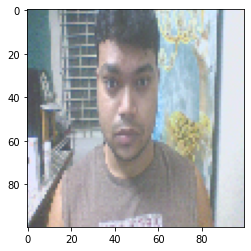

In [ ]:
plt.imshow(IMAGE)

In [ ]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
example = sample.next()

In [ ]:
example


(b'/content/data/anchor/2022-08-31-210634 (1).jpg',
 b'/content/data/positive/2022-08-31-210733.jpg',
 1.0)

# **Build Train and Test**

In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [ ]:
res =preprocess_twin(*example)

In [ ]:
len(res)

3

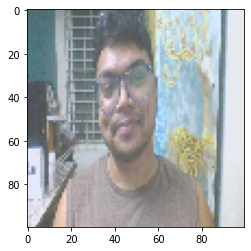

In [ ]:
plt.imshow(res[0])

In [ ]:
# build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [ ]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
len(sample.next())

3

In [ ]:
samp = sample.next()

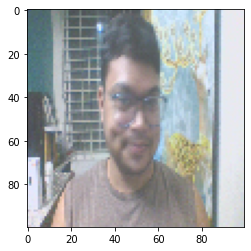

In [ ]:
plt.imshow(samp[0])

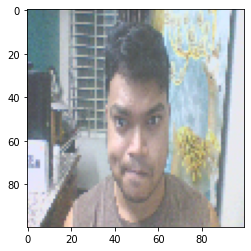

In [ ]:
plt.imshow(samp[1])

In [ ]:
samp[2]

1.0

In [ ]:
# training partition

train_data = data.take(round(len(data)*0.7))

train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [ ]:
# testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.7))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# **Model Building**

In [ ]:
# BUild Embedding layer
def make_embedding():
  input = Input(shape=(100,100,3), name ='Input_Image')

  #First block
  X = Conv2D(64,(10,10), activation = "relu")(input)
  X = MaxPooling2D(64,(2,2), padding = "same")(X)

  # second block
  Y = Conv2D(128,(7,7), activation= "relu")(X)
  Y = MaxPooling2D(64,(2,2), padding = "same")(Y)

  #third block
  Z = Conv2D(128,(7,7), activation= "relu")(Y)
  Z = MaxPooling2D(64,(2,2), padding = "same")(Z)

  # final embedding block
  Z = Conv2D(256,(4,4), activation= "relu")(Z)
  Z = Flatten()(Z)
  out = Dense(4096, activation = "sigmoid")(Z)

  return Model(inputs = [input], outputs = [out], name = "embedding")

In [ ]:
model = make_embedding()

In [ ]:
model.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       80

# **Build Distance layer**

In [ ]:
# Siamese L1 Distance class
class L1Dist(Layer):
  def __init__(self, **kwargs):
    super().__init__()

  def call(self, input_embedding, validation_embedding):
    return tf.math.abs(input_embedding - validation_embedding)  


In [ ]:
## Siamese model
def make_siamese_model():
  # Anchor image input
  input_image = Input(name = "input_img", shape=(100,100,3))

  # validation image 
  validation_image = Input(name = "validation_img", shape= (100,100,3))

  # combine siamese distance
  siamese_layer = L1Dist()
  siamese_layer.name = 'distance'
  distances = siamese_layer(model(input_image), model(validation_image))

  # classification layer

  classifier = Dense(1, activation = "sigmoid")(distances)

  return Model(inputs = [input_image, validation_image], outputs = classifier, name ="SiameseNtework")

In [ ]:
model1 = make_siamese_model()

In [ ]:
model1.summary()

Model: "SiameseNtework"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         18529600    ['input_img[0][0]',              
                                                                  'validation_img[0][

# **Training**

In [ ]:
# setup loss and optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy()

opt =tf.keras.optimizers.Adam(1e-4)

In [ ]:
# Establish Checkpoints
checkpoint_dir = "/content/training_checkpoint"
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = model1)

In [ ]:
# build train step function
@tf.function
def train_step(batch):
  
  with tf.GradientTape() as tape:

    x = batch[:2]

    y = batch[2]

    yhat = model1(x, training =True)

    loss = binary_cross_loss(y, yhat)
  print(loss)  

  grad = tape.gradient(loss, model1.trainable_variables)

  opt.apply_gradients(zip(grad, model1.trainable_variables))
  return loss  



In [ ]:

# building training loop
def train(data, EPOCHS):
  for epoch in range(1, EPOCHS+1):
    print('\n Epoch {}/{}'.format(epoch, EPOCHS))
    progbar = tf.keras.utils.Progbar(len(data))

    # loop through each batch
    for idx, batch in enumerate(data):
      train_step(batch)
      progbar.update(idx+1)

     # save checkpoints
    if epoch % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix) 

In [ ]:
EPOCHS = 60
train(train_data, EPOCHS)


 Epoch 1/60
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
22/22 [==============================] - 18s 206ms/step

 Epoch 2/60
22/22 [==============================] - 4s 193ms/step

 Epoch 3/60
22/22 [==============================] - 4s 192ms/step

 Epoch 4/60
22/22 [==============================] - 4s 191ms/step

 Epoch 5/60
22/22 [==============================] - 4s 190ms/step

 Epoch 6/60
22/22 [==============================] - 4s 190ms/step

 Epoch 7/60
22/22 [==============================] - 4s 188ms/step

 Epoch 8/60
22/22 [==============================] - 4s 188ms/step

 Epoch 9/60
22/22 [==============================] - 4s 187ms/step

 Epoch 10/60
22/22 [==============================] - 4s 186ms/step

 Epoch 11/60
22/22 [==============================] - 4s 182ms/step

 Epoch 12/60
22/22 [==============================] - 4s 182ms/step

 Epoch 13/60
22/22 [=====

In [ ]:
## Evaluation 
from tensorflow.keras.metrics import Precision, Recall

test_input, test_val, y_true = test_data.as_numpy_iterator().next()

# **Predictions**

In [ ]:
y_hat = model1.predict([test_input, test_val])
y_hat

array([[0.01423762],
       [0.99999523],
       [0.9999999 ],
       [0.9999659 ],
       [0.99999845],
       [0.99999356],
       [0.01016082],
       [0.04349006],
       [0.3541589 ],
       [0.9999981 ],
       [0.8887509 ],
       [0.99981076],
       [0.00638461],
       [0.9999982 ],
       [1.        ],
       [0.9999993 ]], dtype=float32)

In [ ]:
# post processing results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1]

In [ ]:
y_true

array([0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1.],
      dtype=float32)

In [ ]:
# creatind metric object
m = Recall()
# calculate recall value
m.update_state(y_true, y_hat)

# return results
m.result().numpy()


1.0

In [ ]:
# creatind metric object
m = Precision()
# calculate precision value
m.update_state(y_true, y_hat)

# return results
m.result().numpy()


1.0

# **EXAMPLES**

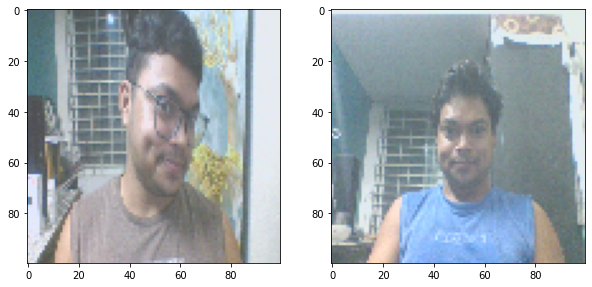

In [ ]:
plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[12])
plt.subplot(1,2,2)
plt.imshow(test_val[12])
plt.show()

In [ ]:
## Save model
model1.save('face_recognition.h5')

In [ ]:
# Reload model
model2 = tf.keras.models.load_model('face_recognition.h5', custom_objects = {'L1Dist':L1Dist,
                                                                             'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
model2.predict([test_input, test_val])

array([[0.01423762],
       [0.99999523],
       [0.9999999 ],
       [0.9999659 ],
       [0.99999845],
       [0.99999356],
       [0.01016082],
       [0.04349006],
       [0.3541589 ],
       [0.9999981 ],
       [0.8887509 ],
       [0.99981076],
       [0.00638461],
       [0.9999982 ],
       [1.        ],
       [0.9999993 ]], dtype=float32)

In [ ]:
model2.summary()

Model: "SiameseNtework"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         18529600    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [ ]:
## Verification 

def verify(frame, model2, detection_threshold, verification_threshold):

  results  =[]
  for image in os.listdir('/content/verification')):

    input_img = preprocess(os.path.join('/content/image_input','/content/verification', 